In [28]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs

%matplotlib inline

FITS_FNAMES = [
    "Inputs/m19_06pp.fits","Inputs/m65_08wp.fits","Inputs/m66_08wp.fits"]

from numba import jit
from numpy import arange

import sys
from acalib.io import container as cont
import glob
from acalib.core.transform import *

In [30]:
def show(name,data):
    #load template
    fig = plt.figure(figsize=(5,5))
    plt.title(name)
    plt.imshow(data,cmap='gray')

@jit
def secure_get(mat,x,y,outside_val):
    if x<0 or y<0 or y>=mat.shape[0] or x>=mat.shape[1]: return outside_val
    else: return mat[y,x]

# Archivos de ejemplo

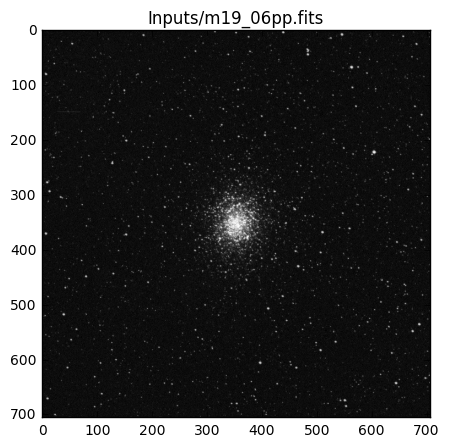

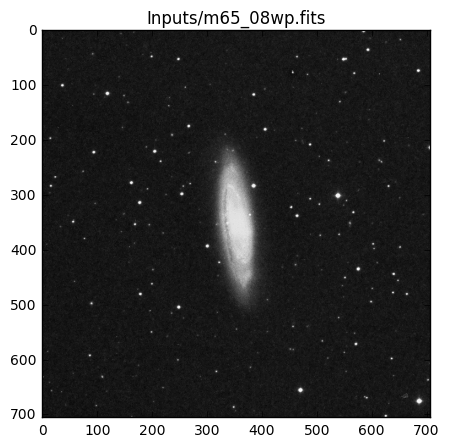

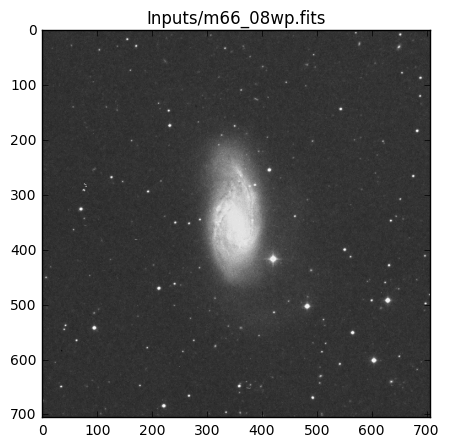

In [23]:
#@@@@@@@ TEST

imgs = [fits.open(fname)[0].data for fname in FITS_FNAMES]

for i in range(len(imgs)):
    show(FITS_FNAMES[i],imgs[i])

# Cropping

## Máscara

`> Desde ahora en adelante se asumirá que las 2 primeras dimensiones son las coordenadas x e y en la imagen y el resto está reservada para cada píxel, pudiendo ser escalares o no.`

`> En el futuro se podría usar clumpfind!`

Para obtener una **máscara** con candidatos a ser la galaxia se obtienen todos los píxeles $\alpha$ veces mayores que el promedio:

In [36]:
def mask_for_cropping(data,alpha=1.5):
    mean = np.mean(data,axis=(0,1))
    mask = np.zeros(data.shape)
    mask[data>mean*alpha] = 1
    return mask

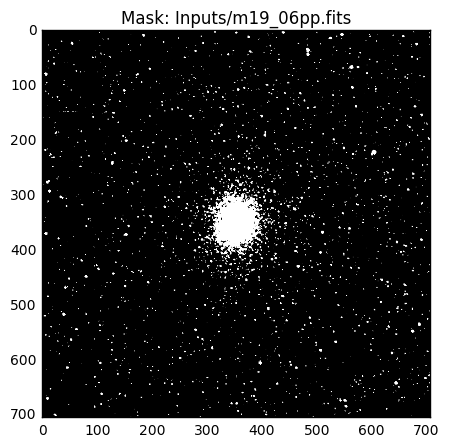

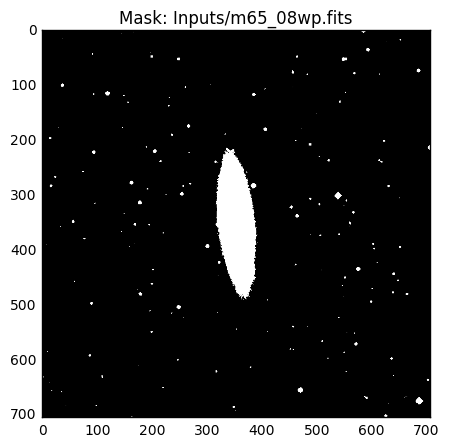

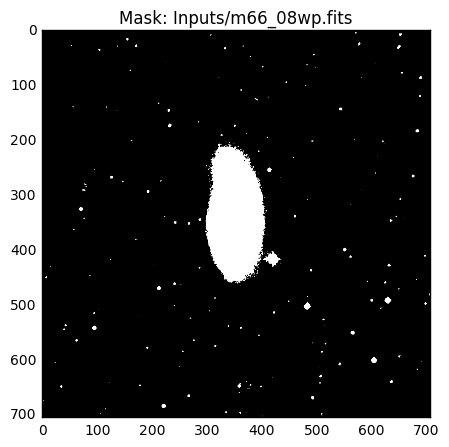

In [37]:
#@@@@@@@ TEST
masks = []
for i in range(len(imgs)):
    masks.append(mask_for_cropping(imgs[i]))
    show("Mask: "+FITS_FNAMES[i],masks[i])

## Mayor clump

Se borra todo de la máscara menos los píxeles conectados al píxel central.

`> Para esto conviene utilizar Numba.`

In [49]:
@jit
def clump_for_cropping(mask,point=None):
    mask = np.copy(mask)
    ADY4 = [(1,0),(0,-1),(-1,0),(0,1)]
    if point==None:
        xc,yc = mask.shape
        point = (xc/2,yc/2)
    stack = [point]
    while len(stack)>0:
        (x,y) = stack.pop()
        if mask[y,x]!=1: continue
        mask[y,x] = 2
        for (dx,dy) in ADY4:
            val = secure_get(mask,x+dx,y+dy,0)
            if val==1:
                stack.append((x+dx,y+dy))
    mask[mask==1] = 0
    mask[mask==2] = 1
    return mask

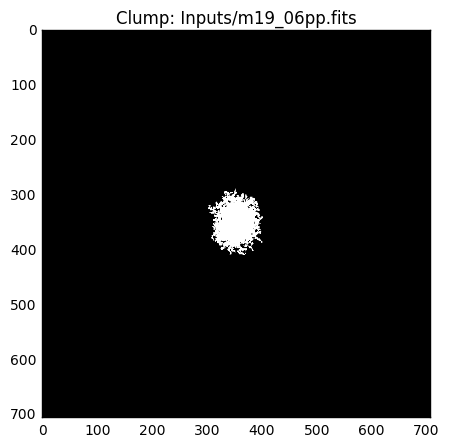

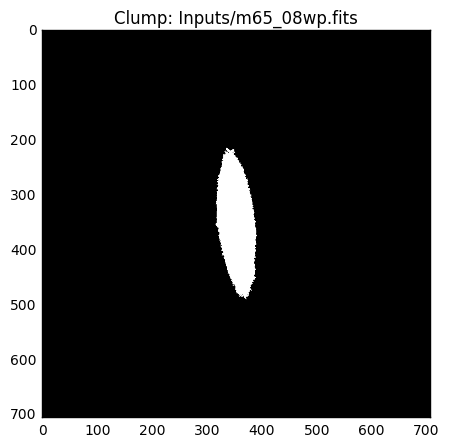

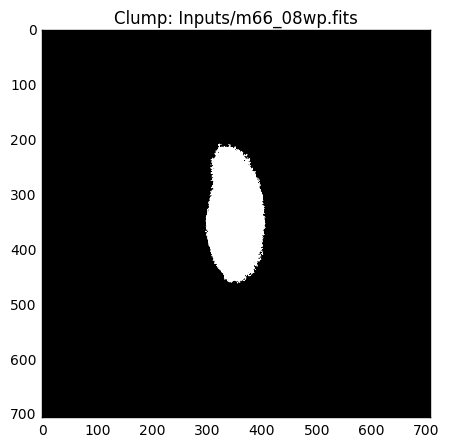

In [50]:
#@@@@@@@ TEST
clumps = []
for i in range(len(masks)):
    clumps.append(clump_for_cropping(masks[i]))
    show("Clump: "+FITS_FNAMES[i],clumps[i])

## Rango del clump

Se obtiene la caja que encierra el clump.

In [ ]:
@jit
def get_clump_ranges(clump):
    yi = clump.shape[0]; yf = 0
    xi = clump.shape[1]; xf = 0
    for y in range(clump.shape[0]):
        for x in range(clump.shape[1]):
            if clump[y,x] > 0:
                if xi > x: xi = x
                if xf < x: xf = x
                if yi > y: yi = y
                if yf < y: yf = y
    return ((xi,xf+1),(yi,yf+1))

## Análisis de Componentes Principales

Se usa el recorte de la imagen y se hace PCA: